In [1]:
from collections import defaultdict
import numpy as np
import pdb

import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_blobs
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
sns.set_style('whitegrid')

from math import log

from sklearn.metrics.pairwise import pairwise_distances

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from clustering_metrics import InternalMetrics
from Wishart import Wishart

In [4]:
n_clusters=3
n_samples=1000

wellsep = make_blobs(n_samples=n_samples, centers=n_clusters, random_state=8)

wellsep_noise_ = make_blobs(n_samples=n_samples-200, centers=n_clusters, random_state=8)
wellsep_noise = (
    np.vstack(
    (
        wellsep_noise_[0], 
        np.random.uniform(wellsep_noise_[0].min(), wellsep_noise_[0].max(), (200,2))
    )
    ),
    np.concatenate([wellsep_noise_[1], [-1] * 200])
)

diff_density = make_blobs(n_samples=[50,100,850], n_features=2, centers=[(-8,-4), (-4,2), (-1,-2)],random_state=8)

skewed_dist = make_blobs(n_samples=n_samples, centers=[(-8,-4), (-4,2), (1,-2)],
                             cluster_std=[1, 0.3, 2],
                             random_state=8)

subclusters = make_blobs(n_samples=n_samples, centers=[(-5,-10), (-5,-5), (7,12), (7,5), (12,-12)], random_state=8)

t4_8k = (np.array(pd.read_csv('t4.8k.txt', sep=' ', header=None).sample(1500)), None)

datasets = list(zip([wellsep, wellsep_noise, diff_density, skewed_dist, subclusters, t4_8k], 
               ['Well separated', 'Well separated with noise', 'Different density', 'Skewed distributions', 'Subclusters', 'T4.8k']))

In [17]:
datasets_clustering = []
for dataset,_ in datasets:
    WC = Wishart(11, 0.02)
    WC.fit(dataset[0])
    datasets_clustering.append((dataset[0], WC))

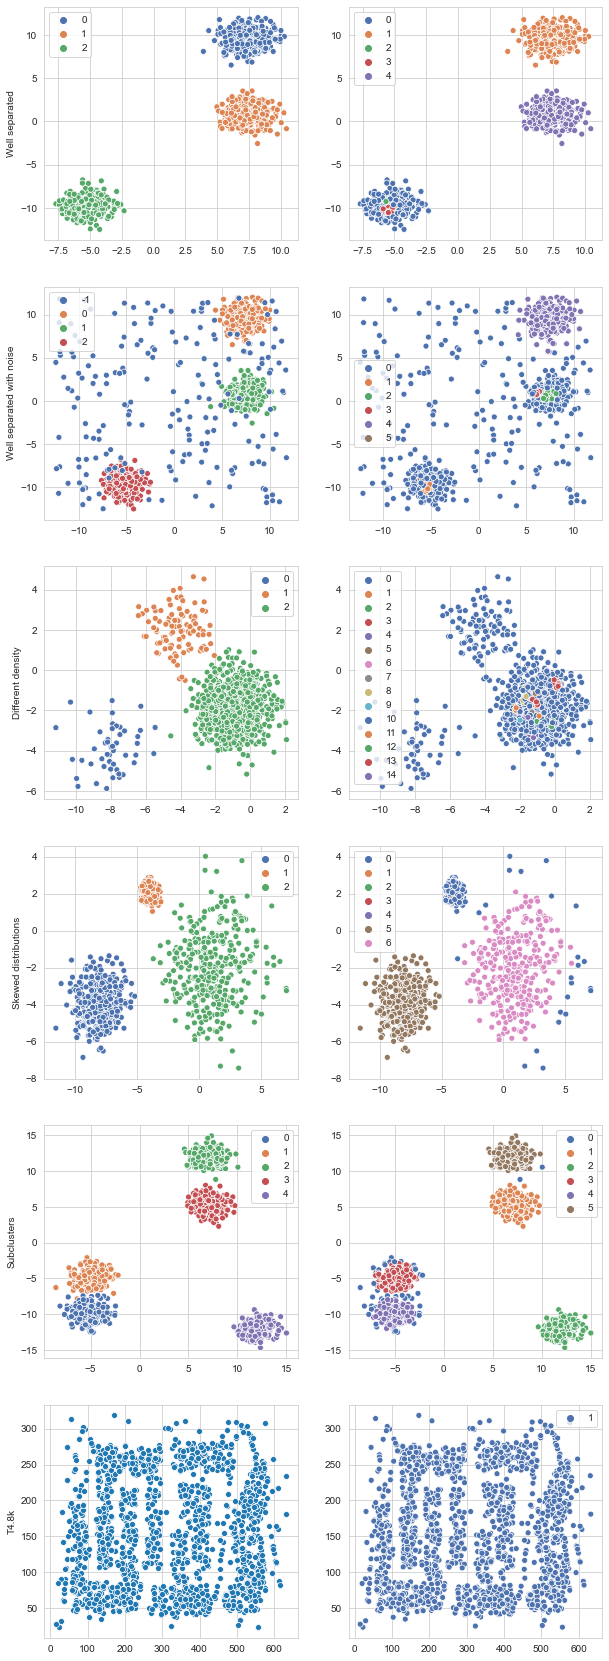

In [19]:
fig,axs = plt.subplots(len(datasets),2, figsize=(10,30))
for i, (((X, y), name), (_, WC)) in enumerate(zip(datasets, datasets_clustering)): 
    sns.scatterplot(X[:,0], X[:,1], hue=y, ax=axs[i][0], legend='full', palette='deep')
    sns.scatterplot(X[:,0], X[:,1], hue=WC.object_labels, ax=axs[i][1], palette='deep')
    axs[i][0].set(ylabel=name)

In [23]:
datasets_names = np.array(datasets)[:,1]
for (data, WC), data_name in zip(datasets_clustering, datasets_names):
    print(data_name)
    if(len(set(WC.object_labels)) == 1):
        print('Set with one cluster')
        continue
    scores = InternalMetrics(data, WC.object_labels, k=10, dk=WC.dk_, dist=WC.dist_).get_scores()
    for key in scores: 
        print('\t' + key + ': %.4f' % scores[key])

Well separated
	RMSSTD: 1.0017
	RS: 0.9800
	silhouette_score: 0.4500
	DB: 2.3035
	XB: 12.9828
	SD: 7.8189
	S_Dbw: 0.2624
	CVNN: 3.6380
Well separated with noise
	RMSSTD: 4.9275
	RS: 0.5233
	silhouette_score: -0.1307
	DB: 1.0628
	XB: 32.1366
	SD: 2.4546
	S_Dbw: 0.9573
	CVNN: 1.7916
Different density
	RMSSTD: 1.8133
	RS: 0.0311
	silhouette_score: -0.4653
	DB: 3.1022
	XB: 65.9958
	SD: 9.0355
	S_Dbw: 0.1057
	CVNN: 2.6338
Skewed distributions
	RMSSTD: 1.5212
	RS: 0.8025
	silhouette_score: 0.1696
	DB: 1.4772
	XB: 225.5153
	SD: 32.9322
	S_Dbw: 0.3786
	CVNN: 3.2183
Subclusters
	RMSSTD: 1.2621
	RS: 0.9765
	silhouette_score: 0.6921
	DB: 1.7481
	XB: 1.7157
	SD: 1.0141
	S_Dbw: 0.2145
	CVNN: 3.1633
T4.8k
Set with one cluster


**Выбор k из np.arange(2, n / 10, 2), h = 0.02 (при разных h метрики выходят на константу примерно на одном и том же значении k (пример есть в более ранних ноутбуках, фиксируем произвольное h, выбираем k))**

In [27]:
metrics_k_grid = defaultdict(list)
k_grid = np.arange(2, 100, 2)

for (X, _), name in datasets:
    metrics_k_grid[name] = defaultdict(list)
    for k in k_grid:
        WC = Wishart(k, 0.02)
        WC.fit(X)
        if len(set(WC.object_labels)) == 1:
            print(name, k)
            break
        scores = InternalMetrics(X, WC.object_labels, k=k, dk=WC.dk_, dist=WC.dist_).get_scores()
        for key in scores:
            metrics_k_grid[name][key].append(scores[key])
        if k == k_grid[-1]: print(name, k)

Well separated 98
Well separated with noise 98
Different density 34
Skewed distributions 98
Subclusters 98
T4.8k 4


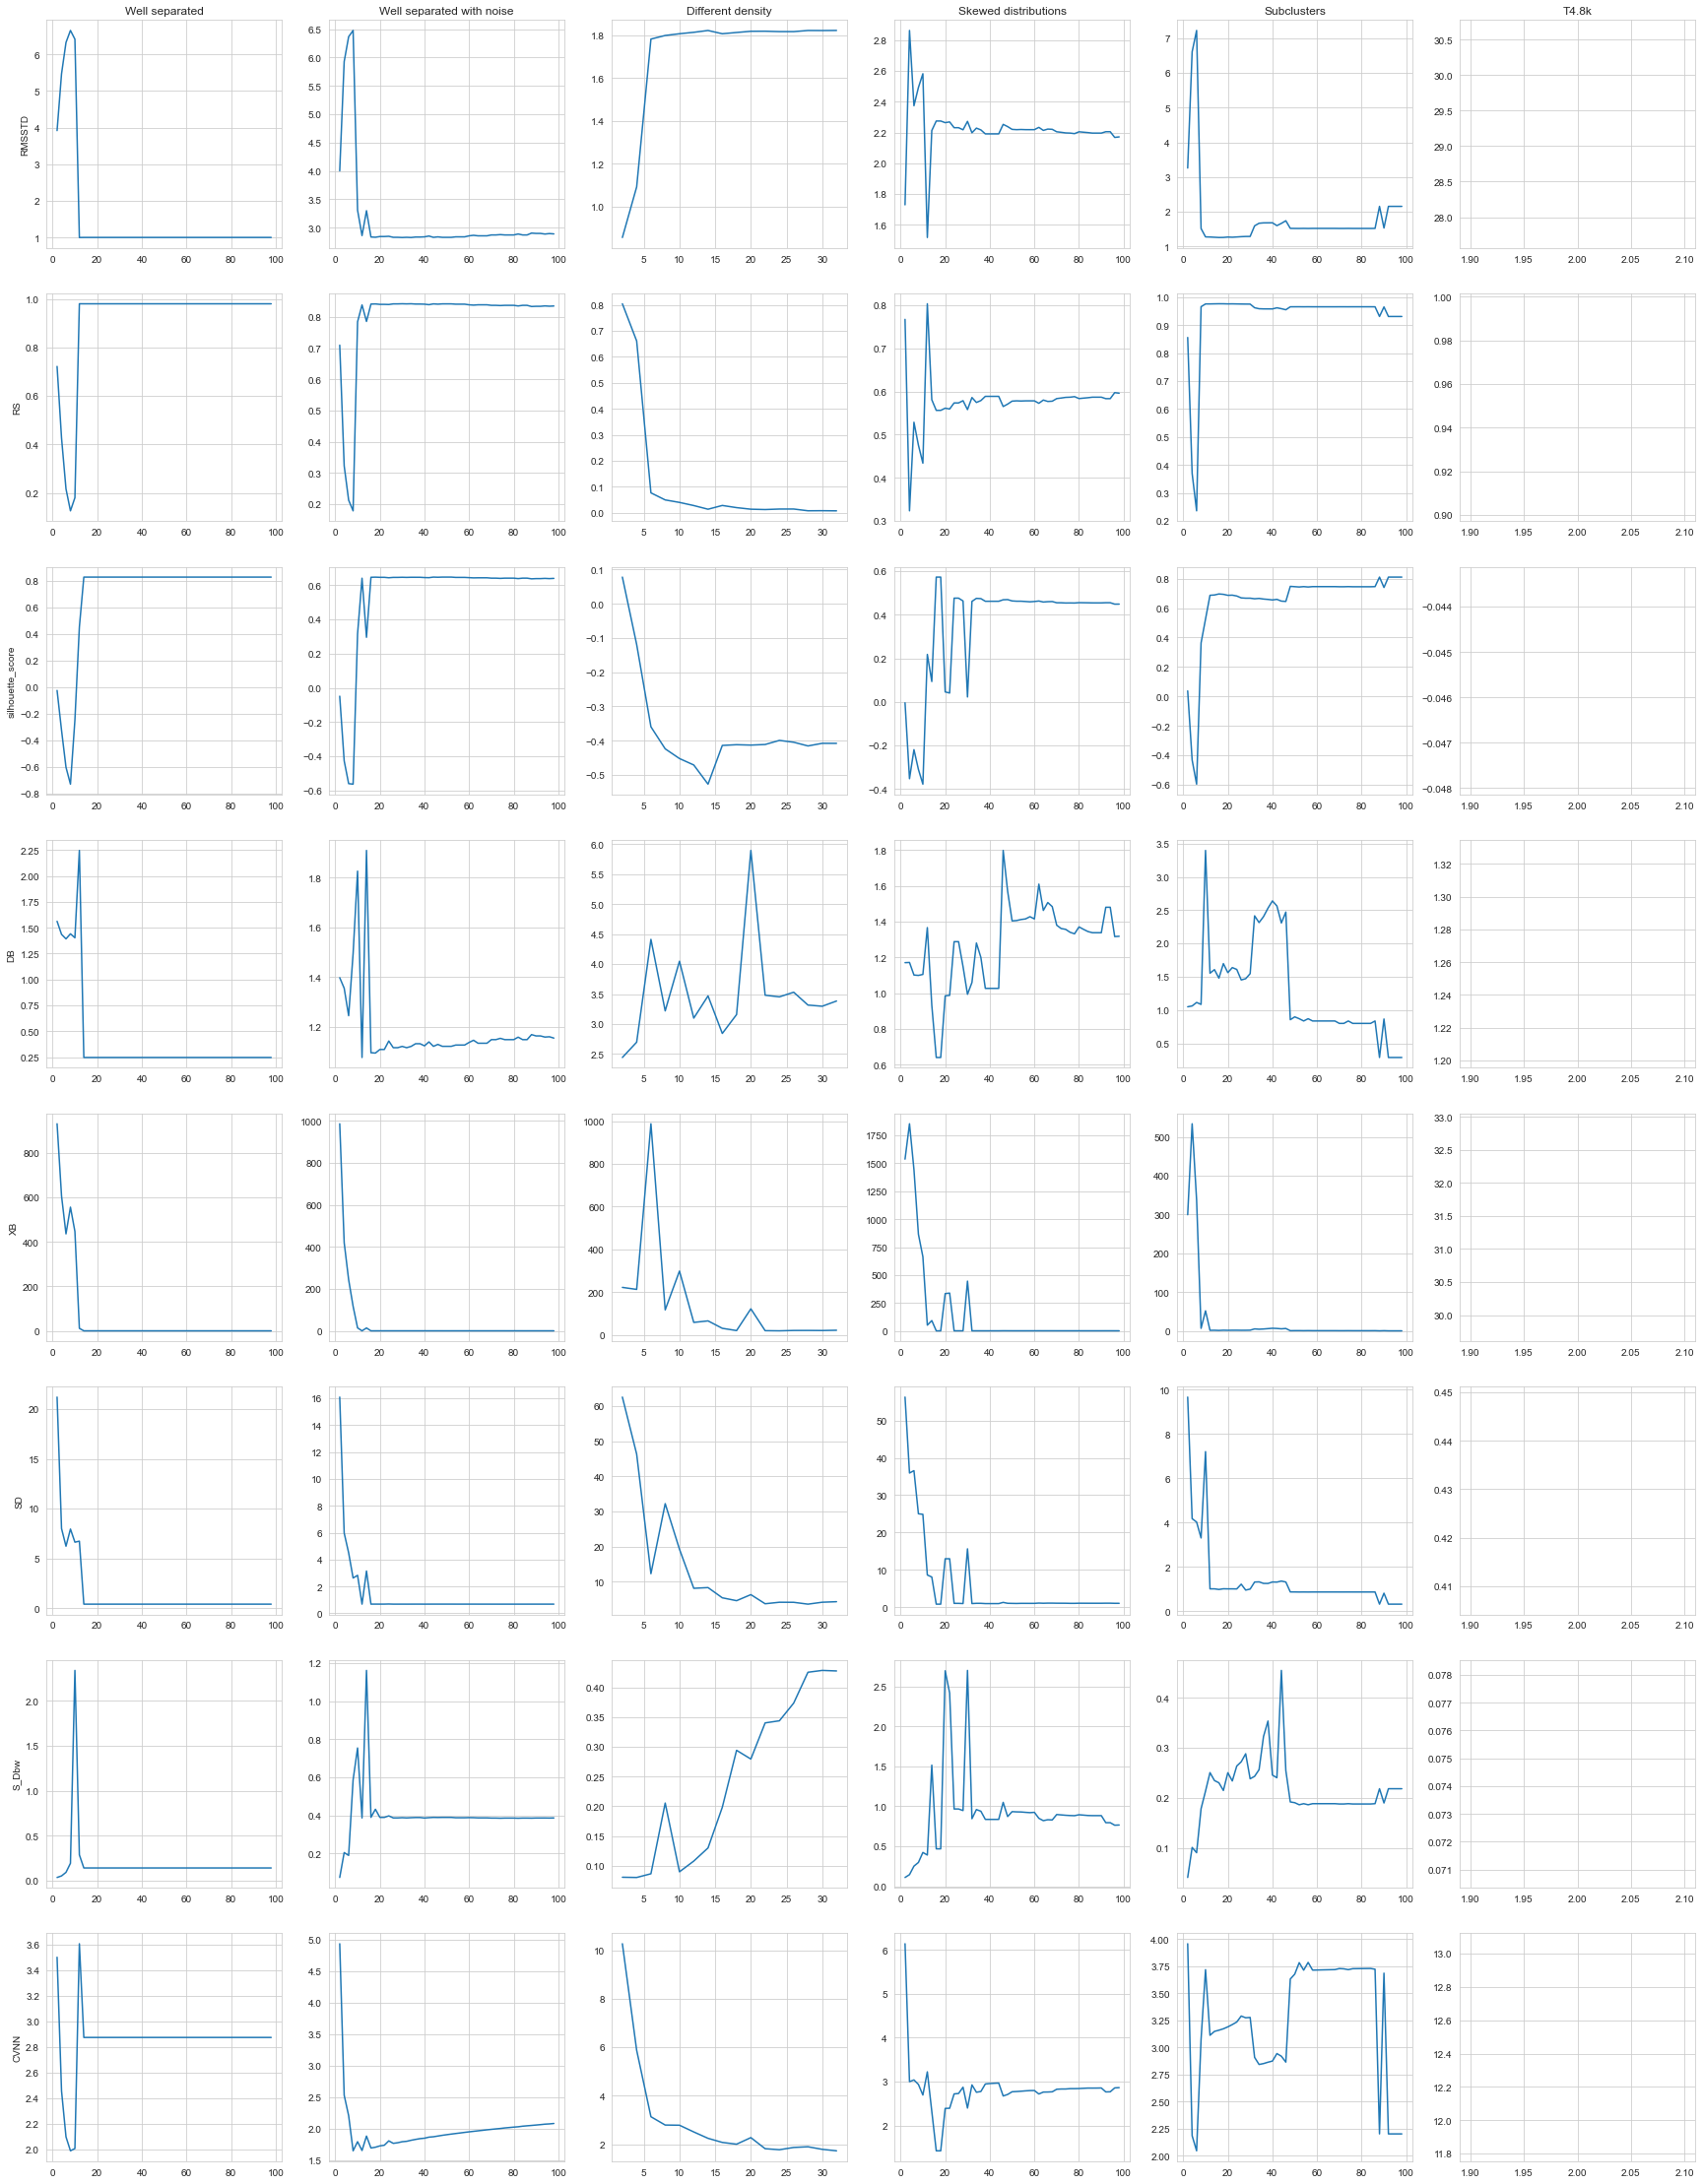

In [28]:
fig, axs = plt.subplots(8,6, figsize=(30,40))
for i in range(8):
    for j in range(6):
        dataname = datasets_names[j]
        if i == 0: axs[i][j].set_title(dataname)
        metricname = list(metrics_k_grid[name].keys())[i]
        y = metrics_k_grid[dataname][metricname]
        axs[i][j].plot(k_grid[:len(y)], y)
        if j == 0: axs[i][j].set(ylabel=metricname)

Лучшие метрики (наиболее консистентные по разным наборам данных, а также выдающие похожие между собой результаты): XB, SD, CVNN (остальные плохи тем, что не выходят на константу - непонятно, как выбирать k).

In [29]:
k_values = [12, 16, 16, 32, 10, 12]    # k values for each dataset

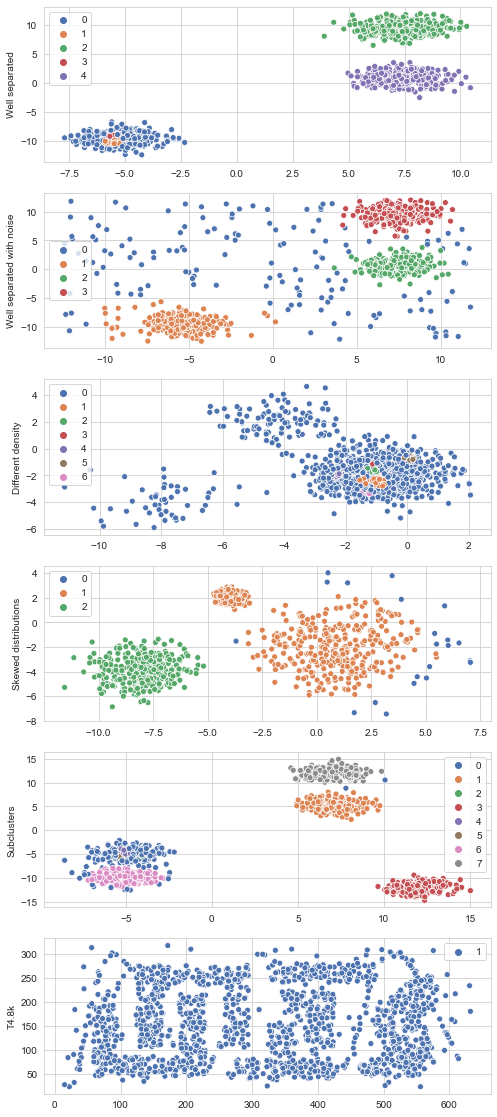

In [32]:
fig,axs = plt.subplots(len(datasets),1, figsize=(8,20))
for i in range(6): 
    WC = Wishart(k_values[i], 0.02)
    X, y = datasets[i][0]
    pred = WC.fit(X).object_labels
    import seaborn as sns
    sns.scatterplot(X[:,0], X[:,1], hue=pred, ax=axs[i], legend='full', palette='deep')
    axs[i].set(ylabel=datasets[i][1])

**Выбор h из np.linspace(0.001, 0.03, 100), k фиксировано из предыдущего пункта.**

In [33]:
metrics_h_grid = defaultdict(list)
h_grid = np.linspace(0.001, 0.03, 100)
for ((X, y), name), k in zip(datasets, k_values):
#    res = pd.DataFrame(X)
#    res['ground truth'] = y
    print(name)
    metrics_h_grid[name] = defaultdict(list)
    for i, h in enumerate(h_grid):
        WC = Wishart(k, h)
        WC.fit(X)
#        res[h] = WC.object_labels
        if len(set(WC.object_labels)) == 1:
            print(h_grid[i-1])
            break
        scores = InternalMetrics(X, WC.object_labels, k=k, dk=WC.dk_, dist=WC.dist_).get_scores()
        for key in scores:
            metrics_h_grid[name][key].append(scores[key])
#    res.to_csv('data.csv', index=None)

Well separated
Well separated with noise
Different density
Skewed distributions
Subclusters
T4.8k
0.03


In [46]:
list(metrics_h_grid[datasets_names[1]].keys())

['RMSSTD', 'RS', 'silhouette_score', 'DB', 'XB', 'SD', 'S_Dbw', 'CVNN']

In [48]:
datasets_names

array(['Well separated', 'Well separated with noise', 'Different density',
       'Skewed distributions', 'Subclusters', 'T4.8k'], dtype=object)

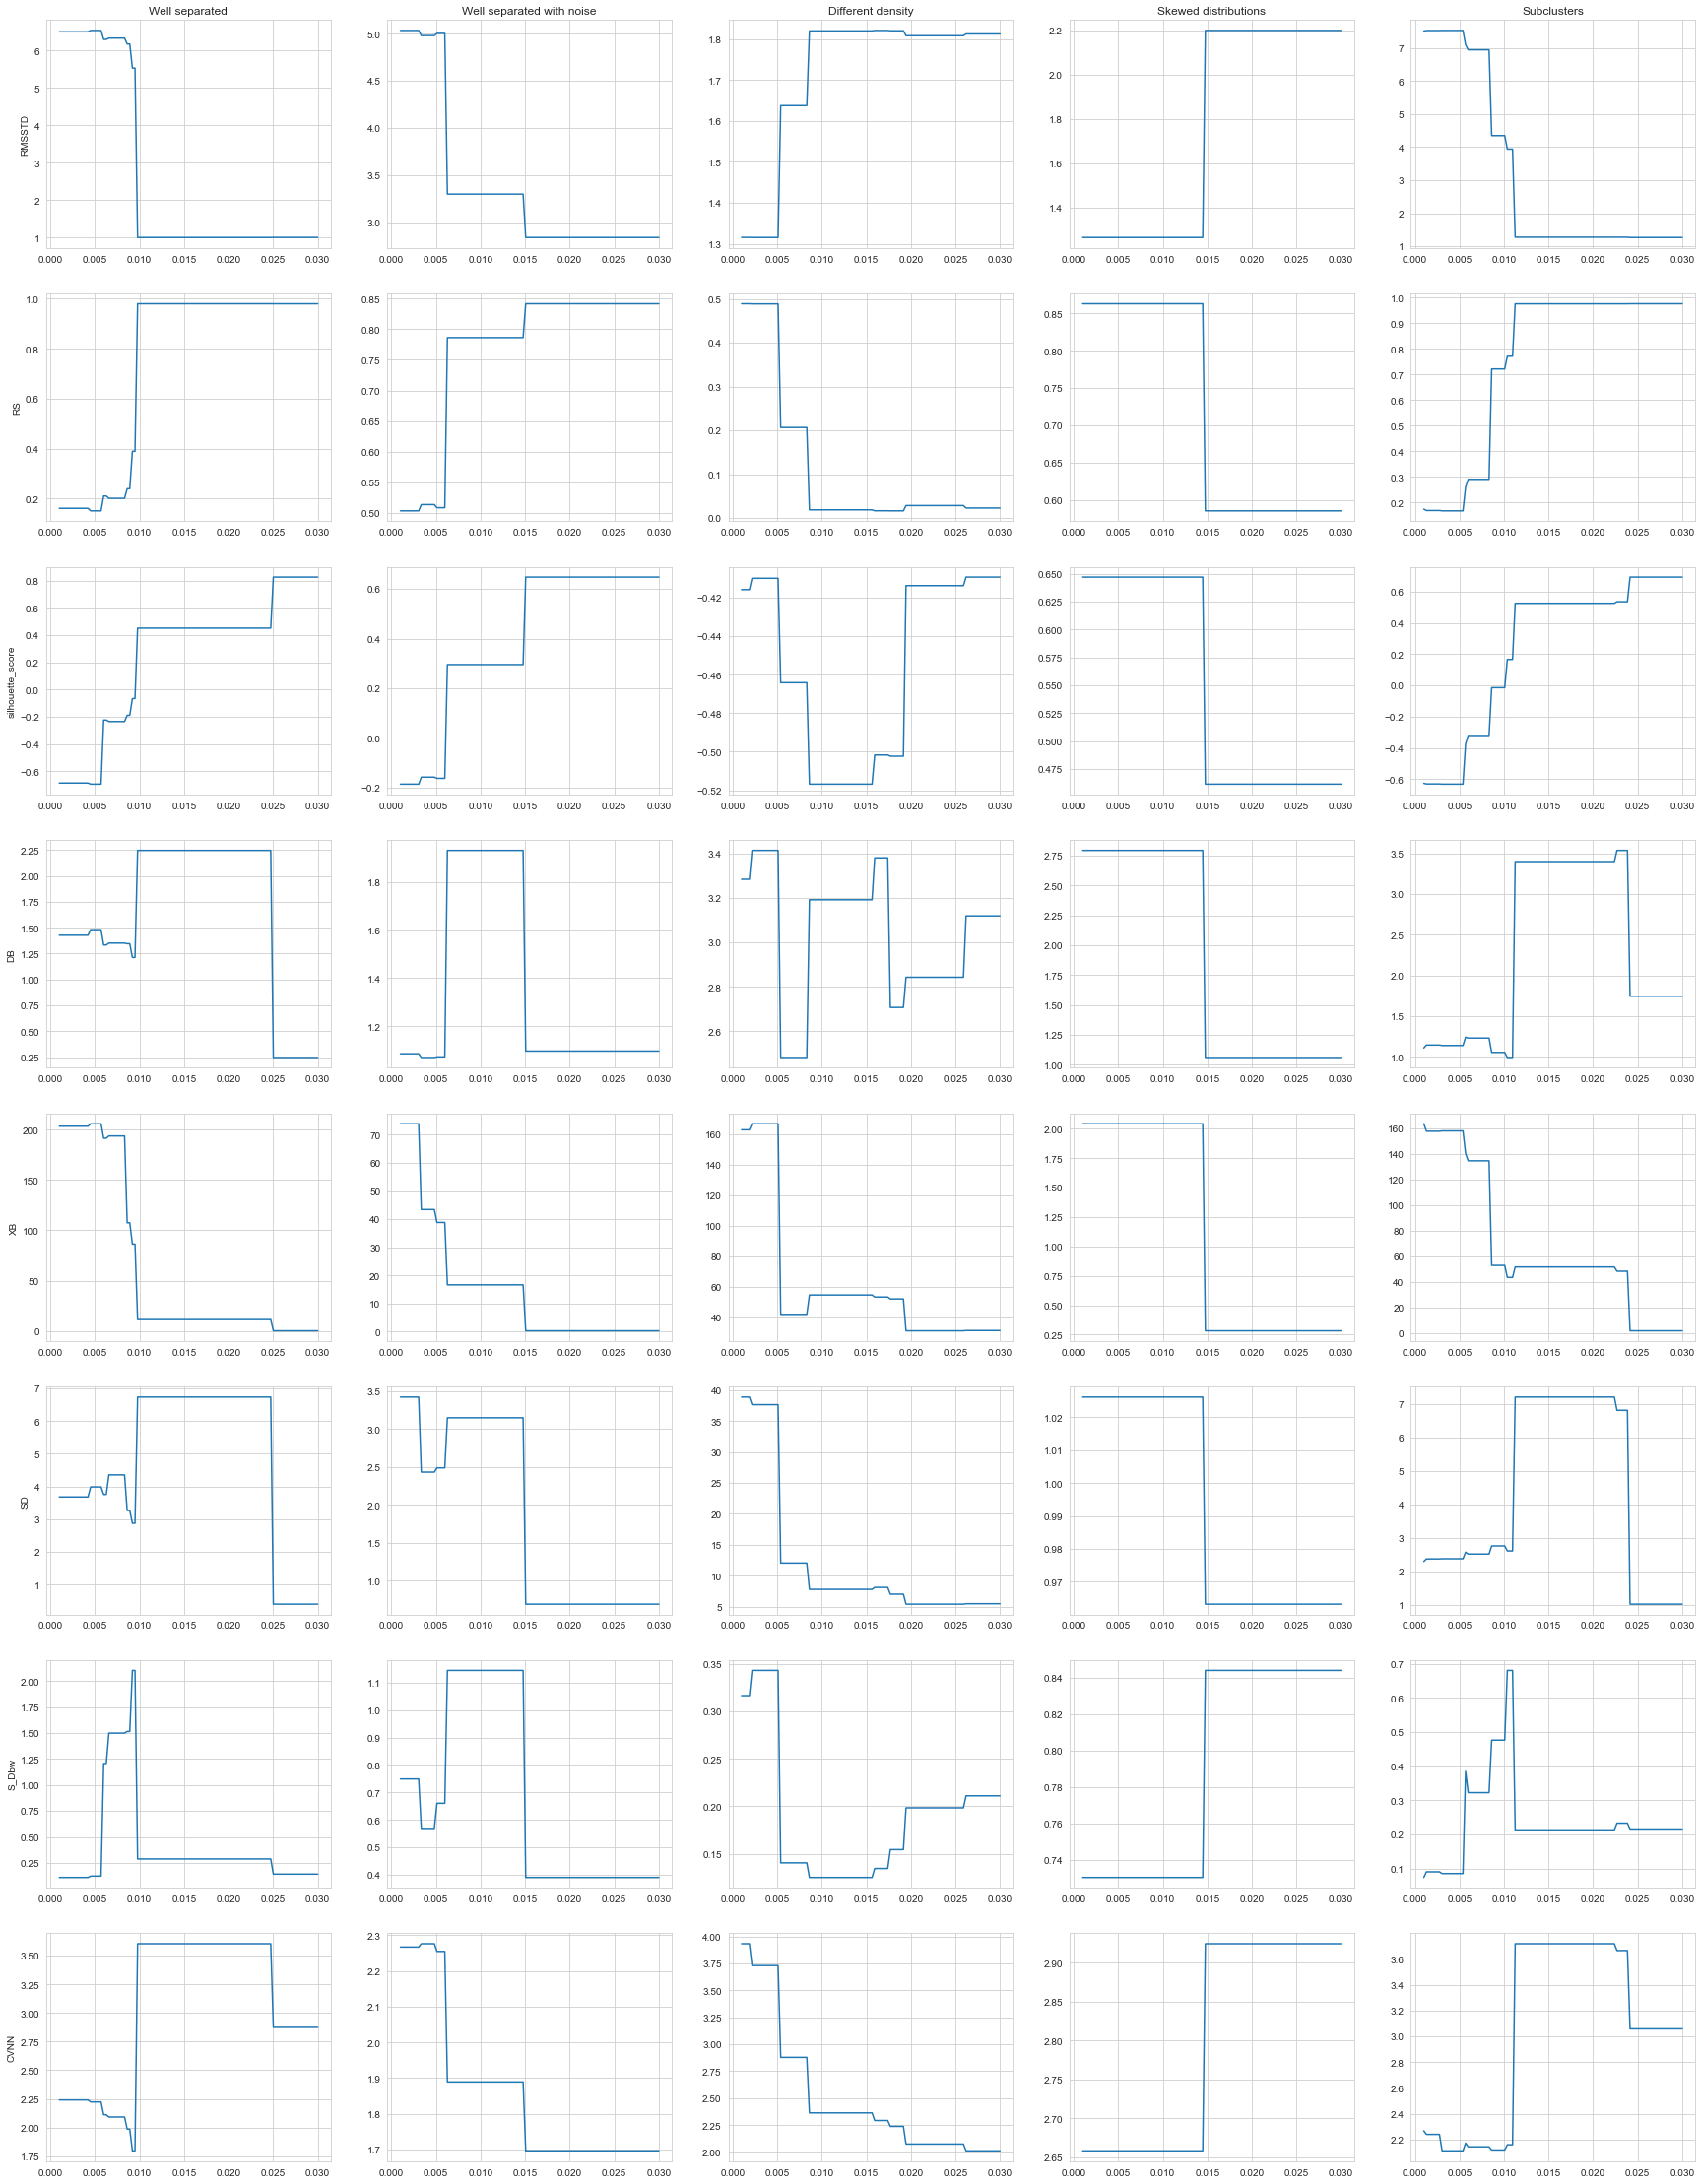

In [51]:
fig, axs = plt.subplots(8,5, figsize=(30,40))
for i in range(8):
    for j in range(5):
        dataname = datasets_names[j]
        if i == 0: axs[i][j].set_title(dataname)
        metricname = list(metrics_h_grid[dataname].keys())[i]
        y = metrics_h_grid[dataname][metricname]
        axs[i][j].plot(h_grid[:len(y)], y)
        if j == 0: axs[i][j].set(ylabel=metricname)

Наиболее точные метрики: RS, RMSSTD, Silhouette, S_Dbw (для других метрик (в том числе XB, CVNN) первое значение, с которого метрика выходит на константу, результирует в более плохой кластеризации)

In [52]:
h_values = [0.01, 0.015, 0.018, 0.015, 0.012, 0.02]

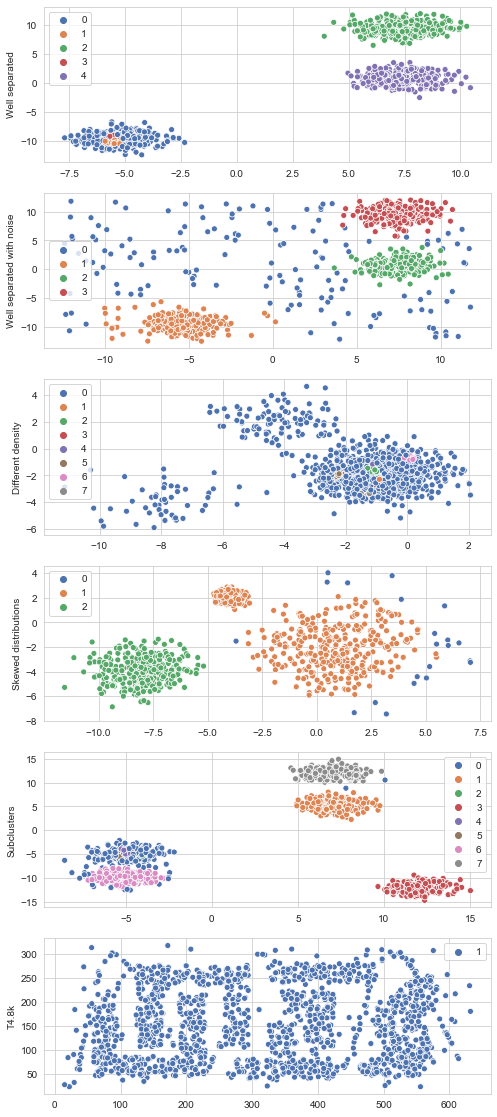

In [53]:
fig,axs = plt.subplots(len(datasets),1, figsize=(8,20))
for i in range(6): 
    WC = Wishart(k_values[i], h_values[i])
    X, y = datasets[i][0]
    pred = WC.fit(X).object_labels
    sns.scatterplot(X[:,0], X[:,1], hue=pred, ax=axs[i], palette='deep')
    axs[i].set(ylabel=datasets[i][1])

Наиболее хорошо по правилам (подбор k по метрикам XB, SD, CVNN и h по RS, RMSSTD, S_Dbw (наименьшее значение, с которого график выходит на константу)) подбираются параметры для всех датасетов, кроме датасета с разными плотностями, в то время как датасет с разными отклонениями распределяется нормально (+для wellsep+noise почему-то не отображается шум (хотя в рез-те для subclusters выделяется пара точек-шумов). 